In [1]:
import numpy as np
import pandas as pd
import DataCsv3
import tensorflow as tf
import os
import sys

In [2]:
x,y = DataCsv.data_csv()

x=x.astype(np.float32)
y=y.astype(np.int32)
print(x.shape)
print(x[0,0,:])

(5026, 77, 9)
[  1.14220446e-02   6.49210334e-01  -4.22500014e-01   1.30463101e-04
   4.21474010e-01   1.78506255e-01   1.49015534e-06   2.73625284e-01
  -7.54188895e-02]


In [3]:
print('This is x.shape:',x.shape,len(x))
print('This is y.shape|len:',y.shape,len(y))
n_values = int(np.max(y)) + 1
print('This is n_values:',n_values)

This is x.shape: (5026, 77, 9) 5026
This is y.shape|len: (5026, 1) 5026
This is n_values: 7


In [4]:
print(y.dtype)

int32


In [5]:
#from sklearn.cross_validation import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
from sklearn.cross_validation import StratifiedShuffleSplit
sss=StratifiedShuffleSplit(y,test_size=0.2,train_size=0.8,random_state=0)
for  train_index,test_index  in  sss:
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
y_train[:10]

array([[5],
       [3],
       [3],
       [4],
       [3],
       [1],
       [4],
       [5],
       [1],
       [3]])

In [7]:
y_test[:10]

array([[2],
       [2],
       [3],
       [1],
       [4],
       [2],
       [3],
       [2],
       [1],
       [4]])

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)  
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [25]:
def deepnn(x):
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 77, 9, 1])

  # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        W_conv1 = weight_variable([9, 3, 1, 5])
        b_conv1 = bias_variable([5])
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)

  # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

  # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        W_conv2 = weight_variable([7, 3, 5, 10])
        b_conv2 = bias_variable([10])
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)

  # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)
        print(h_pool2.shape)
        
    with tf.name_scope('conv3'):
        W_conv3 = weight_variable([5, 3, 10, 20])
        b_conv3 = bias_variable([20])
        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)

  # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool3'):
        h_pool3 = max_pool_2x2(h_conv3)
  # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
  # is down to 7x7x64 feature maps -- maps this to 1024 features.
    with tf.name_scope('fc1'):
        W_fc1 = weight_variable([10 * 2* 20, 200])
        b_fc1 = bias_variable([200])

        h_pool3_flat = tf.reshape(h_pool3, [-1, 10*2*20])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)

  # Dropout - controls the complexity of the model, prevents co-adaptation of
  # features.
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

  # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc2'):
        W_fc2 = weight_variable([200, 7])
        b_fc2 = bias_variable([7])

        y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2
        return y_conv, keep_prob
    
def extract_batch_size(_train, step, batch_size):
    
    shape = list(_train.shape) #_X  7352 128 9
    shape[0] = batch_size      # 1500 128 9
    batch_s = np.empty(shape)

    for i in range(batch_size):
        index = ((step-1)*batch_size + i) % len(_train) # step=1 
        batch_s[i] = _train[index] 

    return batch_s 

def one_hot(y_):
    y_ = y_.reshape(len(y_))
    #n_values = int(np.max(y_)) + 1
    n_values = 7
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

In [26]:
def main():
     
    x = tf.placeholder(tf.float32, [None, 77,9])

    y_ = tf.placeholder(tf.float32, [None, 7])

    y_conv, keep_prob = deepnn(x)

    with tf.name_scope('loss'):
        
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_,
                                                            logits=y_conv)
        cross_entropy = tf.reduce_mean(cross_entropy)

    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        accuracy = tf.reduce_mean(correct_prediction)

    graph_location="/tmp/tensorboard"
    print('Saving graph to: %s' % graph_location)
    train_writer = tf.summary.FileWriter(graph_location)
    train_writer.add_graph(tf.get_default_graph())
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(5600):
            x_batch = extract_batch_size(x_train, i, 200)
            y_batch = one_hot(extract_batch_size(y_train, i, 200))
        
            if i % 200 == 0:
                #x_batc = extract_batch_size(x_test, i, 200)
                #y_batc = one_hot(extract_batch_size(y_test, i, 200))
                
                train_accuracy = accuracy.eval(feed_dict={
                x: x_batch, y_: y_batch, keep_prob: 1.0})
                print('step %d, training accuracy %g' % (i, train_accuracy))
                #train_accuracies.append(train_accuracy)
                loss=sess.run(cross_entropy,feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
                train_losses.append(loss) 
                print ("test accuracy %g"%accuracy.eval(feed_dict={x: x_test, y_: one_hot(y_test), keep_prob: 1.0}))
            train_step.run(feed_dict={x: x_batch, y_: y_batch, keep_prob: 0.5})
        pre = sess.run(y_conv,feed_dict={x: x_test, keep_prob: 1.0})
        pres.append(np.argmax(pre,axis=1))  

In [27]:
train_losses=[]
#train_accuracies=[]
pres = []
print('-----pre----',pres,len(pres))
print('-------------------------')
main()
print(train_losses)
#print(train_accuracies)

-----pre---- [] 0
-------------------------
(?, 20, 3, 10)
Saving graph to: /tmp/tensorboard
step 0, training accuracy 0.13
test accuracy 0.142147
step 200, training accuracy 0.75
test accuracy 0.727634
step 400, training accuracy 0.875
test accuracy 0.835984
step 600, training accuracy 0.92
test accuracy 0.870775
step 800, training accuracy 0.915
test accuracy 0.892644
step 1000, training accuracy 0.955
test accuracy 0.904573
step 1200, training accuracy 0.97
test accuracy 0.905567
step 1400, training accuracy 0.955
test accuracy 0.918489
step 1600, training accuracy 0.98
test accuracy 0.913519
step 1800, training accuracy 0.97
test accuracy 0.907555
step 2000, training accuracy 0.985
test accuracy 0.909543
step 2200, training accuracy 0.98
test accuracy 0.916501
step 2400, training accuracy 0.985
test accuracy 0.917495
step 2600, training accuracy 0.99
test accuracy 0.913519
step 2800, training accuracy 0.995
test accuracy 0.919483
step 3000, training accuracy 0.99
test accuracy 0.92

In [28]:
pres = np.array(pres)
pres = pres.astype(np.int32)
pres = pres.reshape(1006)
y_test = y_test.reshape(1006)

print(pres)
print(y_test)
from sklearn import metrics
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, pres)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)

[3 2 1 ..., 1 5 4]
[3 6 1 ..., 1 5 4]
Confusion Matrix:
[[ 35   0   0   0   0   0   0]
 [  0 283   5   6   6   2   0]
 [  0  10 129   0   4   0   0]
 [  0   5   0 223   1   1   0]
 [  1   8   5   0 164   0   0]
 [  0   7   1   6   3  85   1]
 [  0   1   2   0   0   0  12]]

Confusion matrix (normalised to % of total test data):
[[  3.47912526   0.           0.           0.           0.           0.
    0.        ]
 [  0.          28.13121414   0.49701789   0.59642148   0.59642148
    0.19880715   0.        ]
 [  0.           0.99403578  12.82306194   0.           0.3976143    0.
    0.        ]
 [  0.           0.49701789   0.          22.16699791   0.09940358
    0.09940358   0.        ]
 [  0.09940358   0.7952286    0.49701789   0.          16.30218697   0.
    0.        ]
 [  0.           0.69582504   0.09940358   0.59642148   0.29821074
    8.44930458   0.09940358]
 [  0.           0.09940358   0.19880715   0.           0.           0.
    1.19284296]]


In [29]:
from sklearn.metrics import classification_report
target_names = ['walk','bweep','clean','sweep','daily','dump','run']
print(classification_report(y_test,pres,target_names=target_names))

             precision    recall  f1-score   support

       walk       0.97      1.00      0.99        35
      bweep       0.90      0.94      0.92       302
      clean       0.91      0.90      0.91       143
      sweep       0.95      0.97      0.96       230
      daily       0.92      0.92      0.92       178
       dump       0.97      0.83      0.89       103
        run       0.92      0.80      0.86        15

avg / total       0.93      0.93      0.93      1006



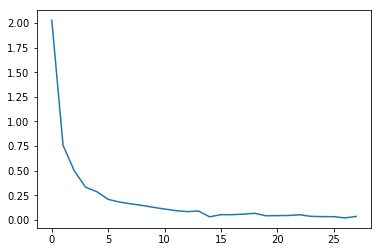

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses)
plt.show()